<a href="https://colab.research.google.com/github/4539453/computational-math/blob/main/sphere_flight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating Sphere Flight

## System

In [1]:
from types import SimpleNamespace
from copy import copy
import pandas as pd


class SettableNamespace(SimpleNamespace):
  """Collection of parameters"""
  def __init__(self, namespace=None, **kwargs):
    super().__init__()
    if namespace:
      self.__dict__.update(namespace.__dict__)
    self.__dict__.update(kwargs)

  def get(self, name, default=None):
    try:
        return self.__getattribute__(name, default)
    except AttributeError:
        return default

  def set(self, **variables):
    # new = copy(self)
    # new.__dict__.update(variables)
    # return new
    return self.__dict__.update(variables)


class System(SettableNamespace):
  pass


class Params(SettableNamespace):
  pass


def State(**variables):
  """Values of state variables"""
  return pd.Series(variables, name='state')


def Vector(x, y):
  return pd.Series(dict(x=x, y=y))


def show(obj):
  """Display a Series or Namespace as a DataFrame"""
  if isinstance(obj, pd.Series):
    df = pd.DataFrame(obj)
    return df
  elif hasattr(obj, '__dict__'):
    return pd.DataFrame(pd.Series(obj.__dict__),
                        columns=['value'])
  else:
    return obj


## Plot

In [2]:
import matplotlib.pyplot as plt

def decorate(**options):
  """decorate(title='Title',
              xlabel='x',
              ylabel='y')
  https://matplotlib.org/api/axes_api.html
  """
  ax = plt.gca()
  ax.set(**options)
  ax.axis('equal')

  handles, labels = ax.get_legend_handles_labels()
  if handles:
      ax.legend(handles, labels)

  plt.tight_layout()

def make_series(x, y):
    if isinstance(y, pd.Series):
        y = y.values
    series = pd.Series(y, index=x)
    # series.index.name = 'index'
    return series


## IVP wrapper

In [3]:
from numpy import linspace
from scipy.integrate import solve_ivp

def TimeFrame(*args, **kwargs):
  """Maps from time to State"""
  return pd.DataFrame(*args, **kwargs)

def run_solve_ivp(system, slope_func, **options):

  t_0 = getattr(system, "t_0", 0)

  events = options.get('events', [])

  # if there's one event, put it in a list
  try:
    iter(events)
  except TypeError:
    events = [events]

  for event in events:
    # make events terminal if not specified
    if not hasattr(event, 'terminal'):
      event.terminal = True

  # run the solver
  bunch = solve_ivp(slope_func, 
                    [t_0, system.t_end],
                    system.init,
                    args=[system],
                    **options)

  # separate the results from the details
  y = bunch.pop("y")
  t = bunch.pop("t")

  columns = system.init.index

  # results at equally-spaced points
  if options.get('dense_output'):
    try:
      num = system.num
    except AttributeError:
      num = 69
    t_final = t[-1]
    t_array = linspace(t_0, t_final, num)
    y_array = bunch.sol(t_array)
    results = TimeFrame(y_array.T, index=t_array, columns=columns)
  else:
    results = TimeFrame(y.T, index=t, columns=columns)

  return results, bunch

## Some math

In [4]:
import numpy as np
from numpy import pi

def pol2cart(alpha: float, radius: float) -> Vector:
  x = radius * np.cos(alpha)
  y = radius * np.sin(alpha)
  return Vector(x, y)

def sphere_mass(diameter: float, rho: float) -> float:
  volume = 4/3 * pi * (diameter/2)**3
  return volume * rho

def vector_norm(v: Vector) -> float:
  return np.linalg.norm(v)

def vector_hat(v: Vector) -> Vector:
  mag = vector_norm(v)
  if mag == 0:
    return v
  else:
    return v / mag

## Simulation

In [5]:
from numpy import pi, deg2rad

def make_system(params: Params) -> System:
  theta = deg2rad(params.angle)
  vx, vy = pol2cart(theta, params.speed)

  init = State(x=params.x, y=params.y, vx=vx, vy=vy)
  middel = pi * (params.diameter/2)**2
  mass = sphere_mass(params.diameter, params.rho)
  return System(params,
                init=init,
                middel=middel,
                mass=mass)

def acceleration(V: Vector, system: System) -> Vector:
  mass, g = system.mass, system.g

  a_drag = drag_force(V, system) / mass
  a_grav = g * Vector(0, -1)
  return a_drag + a_grav
  
def drag_force(V: Vector, system: System) -> Vector:
  C_d, rho_air, middel = system.C_d, system.rho_air, system.middel
  
  magnitude = C_d * rho_air * middel * vector_norm(V)**2 / 2
  direction = -vector_hat(V)
  return  direction * magnitude

In [6]:
from typing import Tuple

def slope_func(t, state: np.ndarray, system: System) -> Tuple:
  x, y, vx, vy = state
  V = Vector(vx, vy)

  A = acceleration(V, system)
  return V.x, V.y, A.x, A.y

def event(t, state, system):
  x, y, vx, vy = state
  return y

In [7]:
params = Params(
  x = 0,            # [m]
  y = 1,            # [m]
  angle = 15,       # [degree]
  speed = 40,       # [m / s]

  diameter = 5e-2,  # [m]
  rho = 27,         # body density [kg/m**3]
  
  C_d = 0.3,        # coef
  rho_air = 1.2,    # [kg/m**3]
  g = 9.8,          # [m/s**2]

  t_end = 10,       # [s]
  num=69            # number of points
)

system = make_system(params)

results, details = run_solve_ivp(
    system,
    slope_func,
    events=event,
    dense_output=True
    )
details.message

'A termination event occurred.'

In [8]:
results

,x,y,vx,vy
0.000000,0.000000,1.000000,38.637033,10.352762
0.017851,0.644751,1.171266,33.809657,8.895247
0.035701,1.213473,1.319393,30.062884,7.744284
0.053552,1.722418,1.448991,27.067000,6.806334
0.071402,2.183117,1.563324,24.612630,6.022096
...,...,...,...,...
1.142438,11.224714,0.350635,3.509155,-4.770546
1.160288,11.286705,0.264893,3.435654,-4.843845
1.178139,11.347392,0.177853,3.363508,-4.915315
1.195990,11.406799,0.089545,3.292684,-4.984966


In [9]:
x_dist = results.iloc[-1].x
x_dist

11.46494904000332

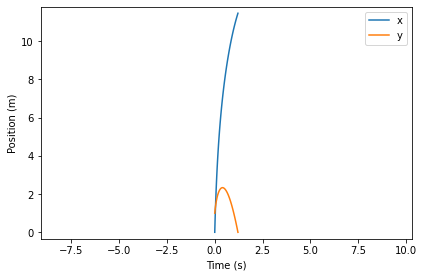

In [10]:
results.x.plot()
results.y.plot()

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

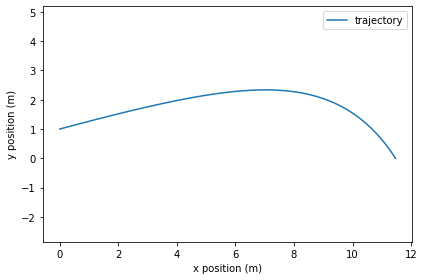

In [11]:
make_series(results.x, results.y).plot(label='trajectory')

decorate(xlabel='x position (m)',
         ylabel='y position (m)')

## Dataset

In [12]:
%%script echo skipping
params = Params(
  x = 0,            # [m]
  y = 0.5,          # [m]
  angle = 85,       # [degree]
  speed = 10,       # [m / s]

  diameter = 5e-2,  # [m]
  rho = 160,        # body density [kg/m**3]
  
  C_d = 0.3,        # coef
  rho_air = 1.8,    # [kg/m**3] https://en.wikipedia.org/wiki/Density_of_air#Dry_air
  g = 9.8,          # [m/s**2]

  t_end = 15,       # [s]
)

show(params)

skipping


In [13]:
%%script echo skipping
system = make_system(params)
results, details = run_solve_ivp(system,
                                 slope_func,
                                 events=event)

results

skipping


In [14]:
%%script echo skipping
from tqdm import tqdm

def make_dataset(params: Params) -> pd.DataFrame:
  df =  pd.DataFrame(columns=params.__dict__.keys())
  df = fill_dataset(df, params)
  return df

def fill_dataset(df: pd.DataFrame, params: Params) -> pd.DataFrame:
  for _ in tqdm(change_params(params)):
    system = make_system(params)
    results, details = run_solve_ivp(system,
                                     slope_func,
                                     events=event)
    result_row = concate(params, results)
    df = df.append(result_row, ignore_index=True)
  return df

def change_params(params: Params) -> Params:
  for angle in range(5, 85, 8):
    params.angle = angle

    for diameter in range(5, 15, 1):
      params.diameter = diameter * 1e-2

      for speed in range(10, 50, 5):
        params.speed = speed

        for y in np.arange(5e-1, 1, 5e-2):
          params.y = y

          yield params

def concate(params: Params, results: pd.DataFrame) -> dict:
  res = params.__dict__
  res['x_dist'] = results.iloc[-1].x
  res['t'] = results.index[-1]
  return res


dataset = make_dataset(params)
dataset = dataset.drop(columns='t_end')

dataset

skipping


In [15]:
%%script echo skipping
from google.colab import files

dataset.to_csv('quasi_experiment_of_sphere_flight.csv', encoding = 'utf-8') 
files.download('quasi_experiment_of_sphere_flight.csv')

skipping


## Models

### Data preporation

In [16]:
from random import seed, uniform
import pandas as pd

seed(7)

def make_noise_data(s: pd.Series, err_presentage: float) -> pd.Series:
  return s + s.apply(lambda x: uniform(-x*err_presentage, x*err_presentage))

data = pd.read_csv('https://gist.githubusercontent.com/4539453/\
406368d0ed2d9d407f4cff1b6b9ef90d/raw/628b65fbc502f0b3ad69df758f4f0e93dcebe015/\
quasi_experiment_of_sphere_flight.csv',
                   index_col=0)

data.x_dist = make_noise_data(data.x_dist, 5e-2)
data.speed  = make_noise_data(data.speed, 2e-2)
data.angle  = make_noise_data(data.angle, 2e-2)
data.y      = make_noise_data(data.y, 2e-2)

data = data.round(2)
data = data.drop(columns=['t'])
# data = data.drop(columns=['t', 'C_d'])
data = data.sample(frac=1, random_state=1).reset_index(drop=True)

data.tail()

,x,y,angle,speed,diameter,rho,C_d,rho_air,g,x_dist
7995,0.0,0.74,77.28,15.13,0.14,160.0,0.3,1.8,9.8,8.04
7996,0.0,0.60,53.36,45.12,0.09,160.0,0.3,1.8,9.8,45.42
7997,0.0,0.50,36.35,40.16,0.14,160.0,0.3,1.8,9.8,58.46
7998,0.0,0.76,5.04,45.02,0.07,160.0,0.3,1.8,9.8,23.76
7999,0.0,0.86,52.99,24.59,0.09,160.0,0.3,1.8,9.8,26.41


### Parameter estimation for DEs

In [17]:
# %%script echo skipping
from scipy.optimize import least_squares, leastsq
from typing import List, Callable, Any

def init_systems(make_system: Callable[[Params], System],
                 data: pd.DataFrame,
                 ) -> List[System]:
  systems = []
  for i in range(0, data.shape[0]):
    params = Params(**data.iloc[i].to_dict())
    params.t_end=15
    systems.append(make_system(params))
  return systems

def calc_deltas(guess: np.ndarray, systems: Any) -> List[float]:
  deltas = []
  for system in systems:
    system.C_d = guess[0]
    results, details = run_solve_ivp(
        system,
        slope_func,
        events=event,
        dense_output=True
        )
    delta = results.iloc[-1].x - system.x_dist
    deltas.append(delta)
  return deltas


systems = init_systems(make_system, data[:1])
guess = [0.1]

guess, covs = leastsq(calc_deltas, guess, args=systems)
guess[0]

0.27698298053877

### Regression... boooooring...